In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
import torch
from torchvision import datasets, transforms, models  # datsets  , transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime

In [31]:
transform = transforms.Compose(
    [transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()]
)

In [32]:
dataset = datasets.ImageFolder("dataset", transform=transform)
dataset

Dataset ImageFolder
    Number of datapoints: 61486
    Root location: dataset
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [33]:
indices = list(range(len(dataset)))
split = int(np.floor(0.85 * len(dataset)))  # train_size
validation = int(np.floor(0.70 * split))  # validation
print(0, validation, split, len(dataset))

0 36584 52263 61486


In [34]:
np.random.shuffle(indices)

In [35]:
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)
targets_size = len(dataset.class_to_idx)

In [36]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)

        # Flatten
        out = out.view(-1, 50176)

        # Fully connected
        out = self.dense_layers(out)

        return out

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [38]:
model = CNN(targets_size).to(device)

In [39]:
criterion = nn.CrossEntropyLoss()  # this include softmax + cross entropy loss
optimizer = torch.optim.Adam(model.parameters())

In [40]:
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            output = model(inputs)

            loss = criterion(output, targets)

            train_loss.append(loss.item())  # torch to numpy world

            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)

        validation_loss = []

        for inputs, targets in validation_loader:

            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)

            loss = criterion(output, targets)

            validation_loss.append(loss.item())  # torch to numpy world

        validation_loss = np.mean(validation_loss)

        train_losses[e] = train_loss
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0

        print(
            f"Epoch : {e+1}/{epochs} Train_loss:{train_loss:.3f} Test_loss:{validation_loss:.3f} Duration:{dt}"
        )

    return train_losses, validation_losses

In [41]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=train_sampler
)
test_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=test_sampler
)
validation_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, sampler=validation_sampler
)

In [42]:
# train_losses, validation_losses = batch_gd(
#     model, criterion, train_loader, validation_loader, 5
# )

In [43]:
# torch.save(model.state_dict() , 'model.pt')

In [44]:
targets_size = 39
model = CNN(targets_size)
model.load_state_dict(torch.load("model.pt"))
model.eval()

C:\Users\NotTheRightGuy\AppData\Local\Temp\ipykernel_3236\952396203.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [45]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [47]:
transform_index_to_disease = dataset.class_to_idx
transform_index_to_disease = dict(
    [(value, key) for key, value in transform_index_to_disease.items()]
)  # reverse the index


In [48]:
data = pd.read_csv("disease_info.csv", encoding="cp1252")

In [51]:
from PIL import Image
import torchvision.transforms.functional as TF

def single_prediction(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    image = image.resize((224, 224))
    input_data = TF.to_tensor(image)
    input_data = input_data.view((-1, 3, 224, 224))
    output = model(input_data)
    output = output.detach().numpy()
    index = np.argmax(output)
    print("Original : ", image_path[12:-4])
    pred_csv = data["disease_name"][index]
    print(pred_csv)

Original :  ple___Apple_scab/image (10)
Apple : Scab


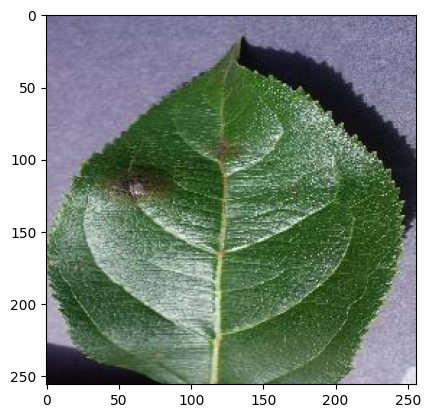

In [52]:
single_prediction("./dataset/Apple___Apple_scab/image (10).JPG")